<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import biom
import matplotlib
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

cyto_dir = '../sfari/data/cytokines'

amp_dir = '../sfari/data/sra'

In [2]:
cyto_md = pd.read_excel(f'{cyto_dir}/Raw cytokine data.xlsx', index_col=0, skiprows=1)
cyto_md = cyto_md[['IL-6.1', 'TGFb.1', 'IL-1b.1', 'IL-4.1', 'IFN-γ.1']]

amp_md = pd.read_table(f'{amp_dir}/Zurita2019/sample_metadata.txt', index_col=0)
amp_md['host_subject_id'] = list(map(lambda x: int(x.split('.')[0][1:]), amp_md.index))

def replace_f(x, fill):
    if x == '.':
        return fill
    else:
        return float(x)

cyto_md['IL-6.1'] = cyto_md['IL-6.1'].apply(lambda x: replace_f(x, 10.))
cyto_md['IL-4.1'] = cyto_md['IL-4.1'].apply(lambda x: replace_f(x, 10.))
cyto_md['IFN-γ.1'] = cyto_md['IFN-γ.1'].apply(lambda x: replace_f(x, 4.69))

def _standardize(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min())
cyto_md = cyto_md.apply(_standardize)


amp_md = pd.merge(amp_md, cyto_md, left_on='host_subject_id', right_index=True)
amp_md.columns = list((map(lambda x: x.replace('.1', ''), amp_md.columns)))
amp_md.columns = list((map(lambda x: x.replace(u'γ', 'gamma'), amp_md.columns)))
amp_md.columns = list((map(lambda x: x.replace('-', ''), amp_md.columns)))

# separate training labels
def train_f(x):
    if np.random.rand() < 0.9:
        return 'Train'
    else:
        return 'Test'
    
amp_md['Train'] = list(map(train_f, amp_md.index))

amp_md.to_csv(f'{amp_dir}/Zurita2019/cytokine_metadata.txt', sep='\t')

Load biom table and save table

In [3]:
table = biom.load_table('../sfari/data/sra/Combined/age_sex_matched-v2.biom')
table.filter(amp_md.index)
table.remove_empty()

584 x 41 <class 'biom.table.Table'> with 5072 nonzero entries (21% dense)

Run statistical tests on cytokines

In [4]:
sub_md = amp_md[['Status', 'Match_IDs', 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']]
sub_md = sub_md.groupby('Match_IDs').filter(lambda x: len(x) == 2)
sub_md = sub_md.sort_values(['Match_IDs', 'Status'])

cols = ['Match_IDs', 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']
match_cytos = sub_md[cols].groupby('Match_IDs').diff().dropna()
cyto_df = pd.melt(match_cytos, var_name='cytokine', value_name='standardized conc.')

<AxesSubplot:xlabel='cytokine', ylabel='standardized conc.'>

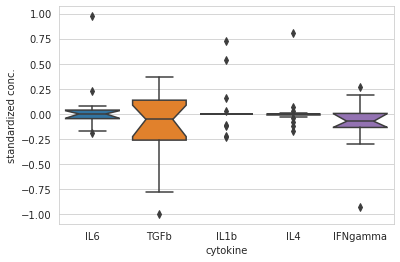

In [5]:
sns.set_style('whitegrid')
sns.boxplot(data=cyto_df, x='cytokine', y='standardized conc.', bootstrap=1000, notch=True)

In [6]:
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon, ttest_rel

asd_md = sub_md.loc[sub_md.Status == 'ASD']
con_md = sub_md.loc[sub_md.Status == 'Control']

cols = [ 'IL6','TGFb', 'IL1b', 'IL4', 'IFNgamma']
for c in cols:
    print(c, ttest_rel(asd_md[c].values, con_md[c].values, alternative='greater'))

IL6 Ttest_relResult(statistic=-0.705296031858368, pvalue=0.755173319057356)
TGFb Ttest_relResult(statistic=1.6432898617050056, pvalue=0.058838012323606886)
IL1b Ttest_relResult(statistic=-0.766474139961866, pvalue=0.7733350439596642)
IL4 Ttest_relResult(statistic=-0.5248488873771839, pvalue=0.6969535623580676)
IFNgamma Ttest_relResult(statistic=1.5307086980563496, pvalue=0.07161339375564173)


In [7]:
wilcoxon(asd_md['IFNgamma'].values, con_md['IFNgamma'].values)

WilcoxonResult(statistic=53.0, pvalue=0.15695518862262656)

In [8]:
ttest_rel(asd_md['IFNgamma'].values, con_md['IFNgamma'].values)

Ttest_relResult(statistic=1.5307086980563496, pvalue=0.14322678751128345)

Look at resulting differentials from songbird

In [9]:
diffs = []
for i in range(1, 13):
    fname = f'{amp_dir}/Zurita2019/cytokine-differentials-{i}/differentials.tsv'
    df = pd.read_table(fname)
    df['sample'] = i
    diffs.append(df)
diffs = pd.concat(diffs)
mean_diff = diffs.groupby('featureid').mean().drop_duplicates()
std_diff = diffs.groupby('featureid').std().drop_duplicates()

In [10]:
len(diffs['featureid'].unique())

303

In [11]:
from q2_matchmaker._stats import spherical_test

In [12]:
res = []
for col in ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']:
    D = pd.pivot(diffs[[col, 'sample', 'featureid']], index='sample', columns='featureid', values=col)
    res.append(spherical_test(D.values, center=False))

In [13]:
res

[(False, 4.3394432144734445, 43.85904575341025),
 (False, 3.6200593543040807, 38.941644019021),
 (False, 4.064829345060673, 49.995799203597),
 (False, 4.187955538720972, 45.73510089667485),
 (False, 4.845021958707392, 64.57855659134559)]

Load taxonomy

Rename feature ids with species names

Cross reference cytokines against differentials

In [14]:
from util import extract_differentials, ranking
from plot import (rankplot, networkplot, vectorplot)

kang_directory = '../sfari/data/sra/Kang2017'

# load differentials
posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'../sfari/data/sra/Combined/age_sex_matched_posterior/amp_differentials-v5.nc'
amp_fname = f'../sfari/data/sra/Zurita2019/age_sex_matched_posterior'
amp_diffs = extract_differentials(amp_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)
amp_stats_all = pd.read_csv('../results/amp_combined_diffs.csv', index_col=0)
amp_stats = pd.merge(amp_stats, amp_stats_all['group'], left_index=True, right_index=True)
#amp_stats = amp_stats.query("group != 'neutral'")

In [15]:
taxonomy = pd.read_table('~/ceph/gg2/2022.8/2022.8.taxonomy.id.tsv', index_col=0)
cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
def taxa_f(x):
    tabs = x.split(';')
    
    def f(y):
        if len(y.split('__')[1]) == '':
            return np.nan
        return y.split('__')[1]
        
    return list(map(f, tabs))
taxa_df = taxonomy.Taxon.apply(taxa_f)
taxa_df_2 = pd.DataFrame(list(taxa_df.values), index=taxa_df.index, columns=cols)
taxa_df_2 = taxa_df_2.replace('', np.nan)
taxa_md = taxa_df_2.loc[amp_stats.index]

In [16]:
amp_stats['group'].value_counts()

num        341
neutral    216
denom       80
Name: group, dtype: int64

In [17]:
mean_diff = diffs.groupby('featureid').mean().drop_duplicates()
std_diff = diffs.groupby('featureid').std().drop_duplicates()

In [18]:
len(diffs['featureid'].unique())

303

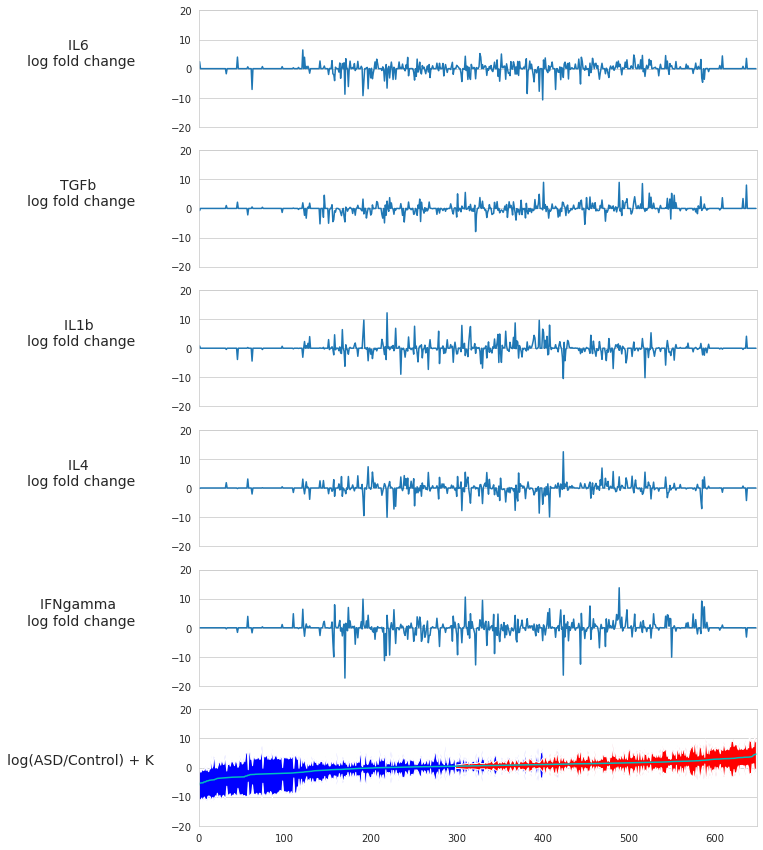

In [19]:
sns.set_style('whitegrid')
cytokine_names = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
fig, ax = plt.subplots(len(cytokine_names) + 1, figsize=(10, 15))
amp_stats = amp_stats.sort_values('mean')
for i, cyto in enumerate(cytokine_names):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    df_stats.index = list(map(str, df_stats.index))
    df_stats = df_stats.reindex(index=amp_stats.index).fillna(0)
    df_stats['ordering'] = np.arange(len(df_stats))
    ax[i].plot(df_stats['mean'])
    #rankplot(df_stats, ax[i], sort_col='ordering')
    ax[i].set_ylabel(f'{cyto} \nlog fold change', rotation=0, labelpad=90, fontsize=14)
    ax[i].set_xticks([])
    ax[i].set_ylim([-20, 20])
    ax[i].set_xlim([0, len(amp_stats)])
rankplot(amp_stats, ax[-1], sort_col='mean')
ax[-1].set_ylim([-20, 20])
ax[-1].set_xlim([0, len(amp_stats)])
ax[-1].grid(False, axis='x')

In [20]:
bugs = ['Enterococcus', 'Bifidobacterium', 
        'Prevotella', 'Desulfovibrio']


def genus_f(x):
    if pd.isnull(x):
        return 'Other'
    if x.split('_')[0] == 'Enterococcus':
        return 'Enterococcus'
    if x.split('_')[0] == 'Desulfovibrio':
        return 'Desulfovibrio'
    if x in bugs:
        return x
    else:
        return 'Other'

taxa_md['genera'] = taxa_md['genus'].apply(genus_f)
#taxa_md['genome'] = taxa_md['genome'].astype(np.int64)

In [21]:
amp_stats = pd.merge(amp_stats, taxa_md, left_index=True, right_index=True)

In [22]:
list(taxa_md['genus'].value_counts().index)

['Bacteroides_E',
 'Prevotella',
 'CAG-110',
 'Blautia_A',
 'CAG-269',
 'Alistipes_A',
 'Barnesiella',
 'CAG-83',
 'Ruminococcus_C',
 'Streptococcus',
 'Lachnospira',
 'CAG-273',
 'Dialister_B',
 'UBA1777',
 'Parabacteroides_B',
 'Phocaeicola',
 'RUG13077',
 'Enterocloster',
 'Veillonella_A',
 'CAG-81',
 'UBA5905',
 'CAG-302',
 'Eubacterium_R',
 'TF01-11',
 'RUG13038',
 'Mediterraneibacter_A',
 'Faecalibacterium',
 'UBA1191',
 'Eubacterium_F',
 'Roseburia',
 'Butyricimonas',
 'SFLA01',
 'Ruminococcus_E',
 'Oribacterium',
 'Anaerobutyricum',
 'Eisenbergiella',
 'Coprococcus_A',
 'UMGS1815',
 'CAG-1427',
 'Acetatifactor',
 'Bifidobacterium',
 'Prevotellamassilia',
 'Clostridium_T',
 'Fusobacterium_C',
 'Erysipelatoclostridium',
 'Butyrivibrio_A',
 'Butyricicoccus_A',
 'Anaerostipes',
 'Porphyromonas_A',
 'Desulfovibrio_R',
 'Akkermansia',
 'Evtepia',
 'GCA-900066135',
 'Anaerotignum',
 'CAG-41',
 'Holdemanella',
 'CAG-460',
 'OEMS01',
 'Lachnoclostridium_B',
 'Leptotrichia_A',
 'Ruminicl

In [23]:
taxa_md['genera'].value_counts()

Other              622
Prevotella          19
Bifidobacterium      4
Desulfovibrio        3
Enterococcus         1
Name: genera, dtype: int64

AB233029                                 Mediterraneibacter glycyrrhizinilyticus
MJ006-1-barcode43-umi202284bins-ubs-3                 Ruminococcus_D bicirculans
MJ006-1-barcode39-umi153479bins-ubs-3                  GCA-900066135 sp900066135
MJ006-1-barcode39-umi159128bins-ubs-3                                        NaN
MJ006-1-barcode39-umi160813bins-ubs-3                      Veillonella_A atypica
                                                          ...                   
G902167945                                                Blautia_A massiliensis
MJ006-1-barcode45-umi157411bins-ubs-3                        CAG-110 sp000434635
HM626177                                                     Blautia_A stercoris
MJ006-1-barcode42-umi174216bins-ubs-3                        Lachnospira eligens
G900538815                                                   CAG-110 sp000434635
Name: species, Length: 301, dtype: object
0.24146693317646375 2.2886457902749247e-05
AB233029                

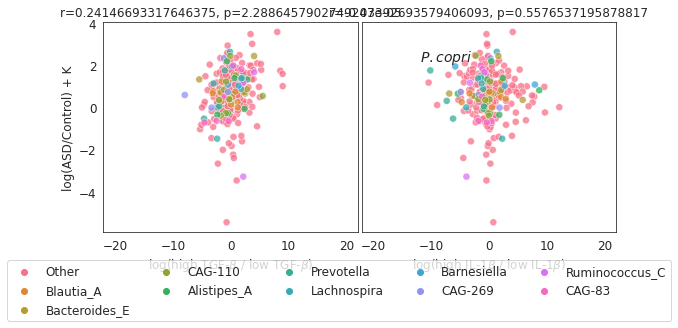

In [27]:
plt.rcParams['text.usetex'] = False
sns.set_style('white')

fs = 12
ls = 12

order = ['Other', 'Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL4' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL1b' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': '$P. copri$', 
               'Enterococcus faecalis': '$E. faecalis$',
               'Bifidobacterium longum': '$B. longum$',
               'Bacteroides_E fragilis': '$B. fragilis$'}
all_texts = []
for i, cyto in enumerate(cytokine_names[1:3]):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    #df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_stats = pd.merge(df_stats, amp_stats, left_index=True, right_index=True, how='outer')
    df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})

    df_stats.index = list(map(str, df_stats.index))    
    #legend = (i == (len(cytokine_names) - 2))
    df_ = df_stats.dropna(subset=['cytokine_mean', 'amp_mean'])
    other_taxa = set((df_stats['genus'].value_counts().head(10)).index)
    df_['ordering'] = df_['genus'].apply(lambda x: x not in other_taxa)
    def other_genus_f(x):
        if x not in other_taxa:
            return 'Other'
        else:
            return x
    df_ = df_.sort_values('ordering', ascending=False)
    df_['other_genus'] = df_['genus'].apply(other_genus_f)
    #df_ = df_.query("other_genus != 'Other'")
    print(df_['species'])
    sns.scatterplot(data=df_, 
                    x='cytokine_mean', y='amp_mean', 
                    hue='other_genus', 
                    ax=ax[i], legend=True, 
                    s=50, 
                    #palette=palette, 
                    alpha=0.75)
    ax[i].set_xlabel(f'log(high {lookup[cyto]} / low {lookup[cyto]})', fontsize=fs)    
    ax[i].set_xlim([-22, 22])
    r, p = pearsonr(df_['cytokine_mean'], df_['amp_mean'])
    print(r, p)
    #r, p = np.round(r, 3), np.round(p, 3)
    #print(r, p)
    ax[i].set_title(f'r={r}, p={p}', fontsize=fs)
    ax[i].tick_params(axis='x', labelsize=ls)
    ax[i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'IL4': 
        dx, dy = 0, 0.1
    if cyto == 'IL1b': 
        dx, dy = -2, 0.1
        
    texts = [ax[i].text(x[j] + dx, y[j] + dy, species_abv[s[j]], fontsize=14,
                        ha='center', va='center') 
             for j in range(len(x))]
    #all_texts += texts
    adjust_text(texts)

ax[0].set_ylabel('log(ASD/Control) + K', fontsize=fs)

h, l = ax[-1].get_legend_handles_labels() # get labels and handles from last figure
#ax[-1].grid(False)
#ax[-1].set_xticks([])
#ax[-1].set_yticks([])
#ax[-1].axis('off')
#ax[-1].legend(h, l, fontsize=14)

fig.legend(h, l, bbox_to_anchor=(0.5, -0.15), loc = 'lower center', ncol=5, fontsize=fs)
plt.subplots_adjust(bottom=0.1, hspace=0.5)

ax[0].legend().remove()
ax[1].legend().remove()

plt.tight_layout(w_pad=0)

In [ ]:
cytokine_names

In [28]:
df = diffs[['featureid', 'IL6', 'sample']].pivot(index='sample', columns='featureid', values='IL6')
il6_stats = ranking(df.T, reference_percentile=50, log_probs=True)[['mean']].rename(columns={'mean': 'IL6'})
il6_stats = pd.concat((amp_stats, il6_stats), axis=1).dropna()

In [29]:
df = diffs[['featureid', 'TGFb', 'sample']].pivot(index='sample', columns='featureid', values='TGFb')
tgf_stats = ranking(df.T, reference_percentile=50, log_probs=True)[['mean']].rename(columns={'mean': 'TGF'})
tgf_stats = pd.concat((amp_stats, tgf_stats), axis=1).dropna()

(0.040177815542646336, 0.5390870091546006)

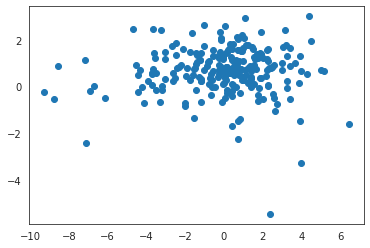

In [30]:
plt.scatter(il6_stats['IL6'], il6_stats['mean'])
pearsonr(il6_stats['IL6'], il6_stats['mean'])

(0.17576005347895146, 0.006792603239488304)

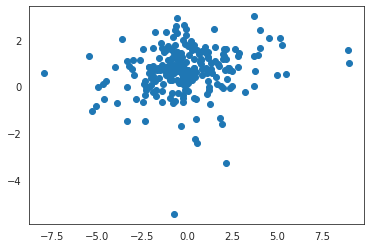

In [31]:
plt.scatter(tgf_stats['TGF'], tgf_stats['mean'])
pearsonr(tgf_stats['TGF'], tgf_stats['mean'])

In [33]:
df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
# realign
df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_index=True, how='outer')
#df_stats['genome'] = df_stats['genome'].astype(np.str)
df_stats = pd.merge(df_stats, amp_stats, left_index=True, right_index=True, how='outer')
df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})

In [34]:
df_stats = ranking(df.T, reference_percentile=50, log_probs=True)

In [35]:
diffs

,featureid,Intercept,IL6,TGFb,IL1b,IL4,IFNgamma,sample
0,MJ006-1-barcode37-umi133973bins-ubs-3,3.914068,1.254718,0.365021,-0.010733,-0.144205,0.110675,1
1,KU298954,1.639744,-6.589746,2.251401,12.284040,-9.754515,4.387176,1
2,MJ006-1-barcode30-umi126369bins-ubs-3,0.534883,-0.689629,-0.571221,7.929983,-9.843083,6.475533,1
3,KX025133,3.488123,-0.843834,-0.034241,5.888570,-3.614446,-1.055800,1
4,MJ006-1-barcode28-umi157746bins-ubs-3,2.340609,-0.971045,0.804999,3.950476,-2.297117,0.978026,1
...,...,...,...,...,...,...,...,...
298,MJ006-1-barcode45-umi38159bins-ubs-10,-0.776130,1.702642,-0.836846,6.050976,-3.134337,-2.405975,12
299,MJ005-barcode73-umi26241bins-ubs-10,-1.564573,0.240024,-0.345281,-0.119890,-0.452612,0.855363,12
300,ABFY02000057,-2.008240,3.053495,1.193020,0.715105,-1.115968,2.105573,12
301,G001553605,-2.067334,2.291879,-0.853183,0.707489,-0.202658,0.080698,12


In [36]:
cytokine_names

['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']

In [37]:
df_stats

,mean,std,5%,50%,95%,counts_bot,counts_top,prob_top,prob_bot,prob_lr,effect_size,effect_std,tstat,pvalue
featureid,,,,,,,,,,,,,,
AB233029,-0.462100,0.233742,-0.818362,-0.424567,-0.160095,0.0,0.0,0.003175,0.003175,0.0,-8.457921,18.303211,-4.839022,5.198059e-04
AB242142,-6.995217,0.311671,-7.418328,-7.000226,-6.646296,0.0,0.0,0.003175,0.003175,0.0,-72.012722,10.294566,-76.242204,2.458828e-16
AB266102,1.179592,0.140568,0.979243,1.183607,1.361373,0.0,0.0,0.003175,0.003175,0.0,59.697917,50.608959,32.410711,2.874104e-12
AB490801,1.947040,0.097765,1.816415,1.923231,2.079424,0.0,0.0,0.003175,0.003175,0.0,203.706349,104.623596,73.793246,3.518961e-16
AB510710,-1.130252,0.206707,-1.426854,-1.100674,-0.879254,0.0,0.0,0.003175,0.003175,0.0,-26.452362,23.403960,-16.669122,3.735817e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MJ032-1-barcode44-umi36862bins-ubs-10,2.135917,0.134232,1.920771,2.172101,2.278982,0.0,0.0,0.003175,0.003175,0.0,118.542351,55.499523,58.620340,4.400157e-15
X72865,2.235715,0.211053,1.922052,2.241709,2.484741,0.0,0.0,0.003175,0.003175,0.0,50.191813,22.450010,38.921121,3.899910e-13
X85101,2.145061,0.139558,1.928601,2.151344,2.323995,0.0,0.0,0.003175,0.003175,0.0,110.136272,51.344132,56.610093,6.451471e-15


In [38]:
cyto = cytokine_names[2]

df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
df_stats = ranking(df.T, reference_percentile=50, log_probs=True)

#df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
#df_stats['genome'] = df_stats['genome'].astype(np.str)
df_stats = pd.merge(df_stats, amp_stats, left_index=True, right_index=True)
df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})

In [39]:
taxa_md

,kingdom,phylum,class,order,family,genus,species,genera
AB037875,Bacteria,Firmicutes_A,Clostridia_A,Peptostreptococcales,Anaerovoracaceae,Mogibacterium,Mogibacterium timidum,Other
AB214328,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_E,Bacteroides_E intestinalis,Other
AB222699,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_E,Bacteroides_E finegoldii,Other
AB233029,Bacteria,Firmicutes_A,Clostridia_A,Lachnospirales,Lachnospiraceae,Schaedlerella,Mediterraneibacter glycyrrhizinilyticus,Other
AB242142,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei,Other
...,...,...,...,...,...,...,...,...
X87151,Bacteria,Firmicutes_A,Clostridia_A,Lachnospirales,Lachnospiraceae,Catonella,Catonella morbi,Other
X87758,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,Micrococcaceae,Rothia,Rothia mucilaginosa,Other
X94967,Bacteria,Firmicutes_A,Clostridia_A,Lachnospirales,Lachnospiraceae,Ruminococcus_B,Ruminococcus_B gnavus,Other
X96961,Bacteria,Firmicutes_A,Clostridia_A,Eubacteriales,Eubacteriaceae,Eubacterium_O,Eubacterium_O callanderi,Other


In [40]:
cytokine_names

['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']

Look at the differentials to make sure the ordering is correct

In [41]:
counts = table.to_dataframe().T
counts = counts.loc[amp_md.index]
cols = ['IL6', 'TGFb', 'IL1b', 'IL4']
avg_diffs = diffs[['featureid'] + cols + ['sample']].groupby('featureid').mean()
avg_diffs = avg_diffs[cols]
avg_diffs.index = list(map(str, avg_diffs.index))

taxmd = taxa_md.copy()
#taxmd['genome'] = taxmd['genome'].astype(np.str)
#taxmd = taxmd.set_index('genome').loc[counts.columns]
taxmd = taxmd[~taxmd.index.duplicated(keep='first')]

In [42]:
def top_balance(cts, vec, k):
    svec = vec.sort_values()
    lo = svec.head(k).index
    hi = svec.tail(k).index
    num = np.log(cts.loc[:, hi] + 1).mean(axis=1)
    denom = np.log(cts.loc[:, lo] + 1).mean(axis=1)
    balance = num - denom
    return balance

def microbe_balance(cts, taxa_md):
    """ \log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio}) """
    ent = np.log(cts.loc[:, taxa_md['genus'] == 'Enterococcus'] + 1).mean(axis=1)
    bif = np.log(cts.loc[:, taxa_md['genus'] == 'Bifidobacterium'] + 1).mean(axis=1)
    prv = np.log(cts.loc[:, taxa_md['genus'] == 'Prevotella'] + 1).mean(axis=1)
    dsv = np.log(cts.loc[:, taxa_md['genus'] == 'Desulfovibrio'] + 1).mean(axis=1)
    num = ent + bif
    denom = prv + dsv
    balance = num - denom
    return balance

IL6 (0.6770905810878083, 1.1672093648772067e-06)
TGFb (0.6455222890174972, 5.186053744960649e-06)
IL1b (0.35349534029175245, 0.023376232921018487)
IL4 (0.29635194663990877, 0.05991702500037362)


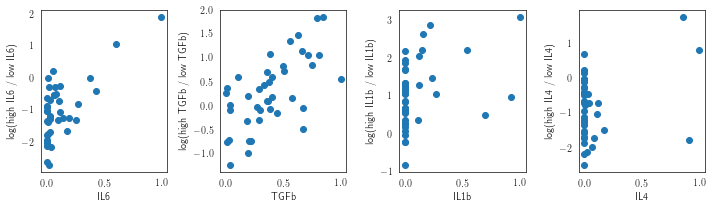

In [43]:
plt.rcParams['text.usetex'] = True

k = 30
fig, ax = plt.subplots(1, len(cols), figsize=(10, 3))
for i, cyto in enumerate(cols):
    il = top_balance(counts, avg_diffs[cyto], k)
    print(cyto, pearsonr(amp_md[cyto], il))
    ax[i].scatter(amp_md[cyto], il)
    ax[i].set_xlabel(cyto)
    ax[i].set_ylabel(f'log(high {cyto} / low {cyto})')
#ax[0].set_xlabel('IL-1$\beta$')
#ax[0].set_xlabel('IL-1')
plt.tight_layout()

<AxesSubplot:xlabel='TGFb', ylabel='Density'>

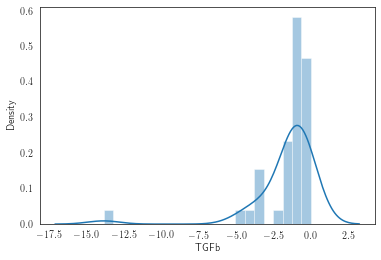

In [44]:
eps = 1e-6
sns.distplot(np.log(amp_md['TGFb'] + eps))

Text(0, 0.5, 'IL-1b')

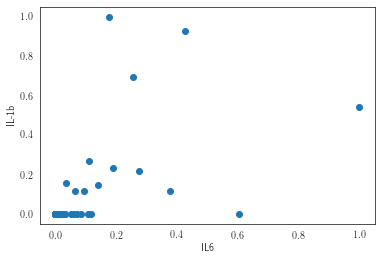

In [45]:
plt.scatter(amp_md['IL6'], amp_md['IL1b'])
plt.xlabel('IL6')
plt.ylabel('IL-1b')

Final figure

In [46]:
df_stats.query("genera != 'Other'")

,cytokine_mean,std_x,5%_x,50%_x,95%_x,counts_bot_x,counts_top_x,prob_top_x,prob_bot_x,prob_lr_x,...,pvalue_y,group,kingdom,phylum,class,order,family,genus,species,genera
G001553605,0.764466,0.160946,0.614945,0.693643,1.046168,0.0,0.0,0.003175,0.003175,0.000000,...,1.576051e-135,denom,Bacteria,Desulfobacterota_G,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Desulfovibrio_R,Desulfovibrio_R fairfieldensis,Desulfovibrio
G004570995,-0.518040,0.150696,-0.699358,-0.551973,-0.288995,0.0,0.0,0.003175,0.003175,0.000000,...,1.224823e-07,neutral,Bacteria,Firmicutes_D,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus_D,Enterococcus_D gallinarum,Enterococcus
G900539795,-0.866518,0.264416,-1.186195,-0.860882,-0.446085,0.0,0.0,0.003175,0.003175,0.000000,...,2.467164e-04,num,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella sp003447235,Prevotella
KF990498,9.671609,0.121627,9.522373,9.669891,9.848028,0.0,0.0,0.003175,0.003175,0.000000,...,4.743848e-38,num,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium faecale,Bifidobacterium
KU298954,12.156070,0.342273,11.838761,12.005935,12.756953,0.0,12.0,0.041270,0.003175,2.564949,...,3.338679e-17,num,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium callitrichidarum,Bifidobacterium
MJ006-2-barcode59-umi236265bins-ubs-3,-10.129814,0.317045,-10.564125,-10.101326,-9.758435,0.0,0.0,0.003175,0.003175,0.000000,...,1.031057e-49,denom,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella copri,Prevotella
MJ006-2-barcode73-umi142785bins-ubs-3,-6.194661,0.085177,-6.298446,-6.205539,-6.047246,0.0,0.0,0.003175,0.003175,0.000000,...,1.668953e-19,neutral,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella copri,Prevotella
MJ006-2-barcode73-umi164914bins-ubs-3,-7.291521,0.412098,-8.023284,-7.128257,-6.870602,0.0,0.0,0.003175,0.003175,0.000000,...,2.519686e-01,num,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella copri,Prevotella


IL6 (0.6770905810878083, 1.1672093648772067e-06)
TGFb (0.6455222890174972, 5.186053744960649e-06)
                                       cytokine_mean  amp_mean       std  \
G001553605                                  2.384881 -5.440083  3.046361   
MJ006-2-barcode73-umi142785bins-ubs-3      -8.787338 -0.536032  1.935609   
KF990498                                   -4.415176 -0.243294  0.874837   
KU298954                                   -6.693660  0.005984  0.859537   
G004570995                                 -3.197517  0.023659  1.343231   
G900539795                                  0.481002  0.046108  1.834907   
MJ006-2-barcode73-umi164914bins-ubs-3      -1.158613  0.303835  1.423333   
MJ006-2-barcode59-umi236265bins-ubs-3      -2.671211  1.744978  1.587031   

                                                                species  
G001553605                               Desulfovibrio_R fairfieldensis  
MJ006-2-barcode73-umi142785bins-ubs-3                  Prevotella cop

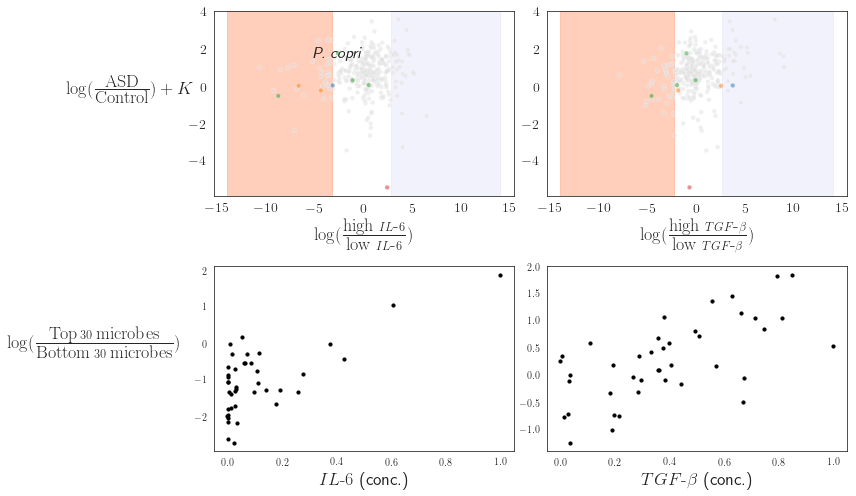

In [48]:
plt.rcParams['text.usetex'] = True
sns.set_style('white')

fs = 18
ls = 14

order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio', 'Other']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = '#808080'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL6', 'TGFb', 'IL1b', 'IL4', 'IFNgamma']
#cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
cytokine_v = [r'IL\textrm{-}6', r'TGF\textrm{-}\beta', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharey=False)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL6' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL6' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': 'P. copri', 
               'Enterococcus faecalis': 'E. faecalis',
               'Bifidobacterium longum': 'B. longum'}

## Scatter plots against cytokine concentrations
j = 1
eps = 1e-6
for i, cyto in enumerate(cols[:2]):
    il = top_balance(counts, avg_diffs[cyto], k)
    #il = microbe_balance(counts, taxmd)
    ax[j][i].scatter(amp_md[cyto], il, color='k', s=10)
    print(cyto, pearsonr(amp_md[cyto], il))
    #ax[j][i].set_ylabel(f'log(high {cyto} / low {cyto})')
    ax[j][i].set_ylabel('')
    ax[j][i].set_xlabel('$' + cytokine_v[i] + '$ (conc.)', fontsize=fs)
    #ax[j][i].set_ylim([-3, 3])
    #ax[j][i].set_xlim([-0.05, 1.05])
    
#ylabel = r'$\log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio})$'
ylabel = r'$\log(\frac{\textrm{Top} \;' + str(k) + '\; \\textrm{microbes}}{\\textrm{Bottom} \;' + str(k) + '\; \\textrm{microbes}})$'
ax[j][0].set_ylabel(ylabel, fontsize=fs, labelpad=100, rotation=0)
    
all_texts = []
j = 0
for i, cyto in enumerate(cytokine_names[:2]):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    #df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_ = df_stats[['mean']]
    df_ = df_.rename(columns={'mean': 'cytokine_mean'})
    df_stats = pd.merge(df_, amp_stats, left_index=True, right_index=True)
    df_stats = df_stats.rename(columns={'mean': 'amp_mean'})
    
    df_stats.index = list(map(str, df_stats.index))    
    legend = (i == (len(cytokine_names) - 2))
    #ax[j][i].vlines(lo, -1.2, 1.2, 'r', linestyle=':')
    #ax[j][i].vlines(hi, -1.2, 1.2, 'r', linestyle=':')
    lo = df_stats['cytokine_mean'].sort_values().iloc[k]
    hi = df_stats['cytokine_mean'].sort_values().iloc[-k]
    ax[j][i].axvspan(hi, 14, alpha=0.5, color='lavender', zorder=0)
    ax[j][i].axvspan(-14, lo, alpha=0.5, color='lightsalmon', zorder=0)
    
    df_stats['ordering'] = (df_stats['genera'] != 'Other')
    df_stats = df_stats.sort_values('ordering')
    
    print(df_stats.query("genera != 'Other'").sort_values('amp_mean')[print_cols])
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[j][i], legend=legend,  zorder=10,
                    s=20, hue_order=order, palette=palette, alpha=0.5)
    xlabel = r'$\log(\frac{\textrm{high }' + lookup[cyto] + '}{ \\textrm{low }' +  lookup[cyto] + '})$'
 
    
    ax[j][i].set_xlabel(xlabel, fontsize=fs)
    ax[j][i].set_ylabel("")
    #ax[j][i].set_xlim([-11, 11])
    #ax[j][i].set_ylim([-1.2, 1.2])
    ax[j][i].tick_params(axis='x', labelsize=ls)
    ax[j][i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'TGFb': 
        dx, dy = 0, 0
    if cyto == 'IL6': 
        dx, dy = 0, 0
    
    texts = [ax[j][i].text(x[k] + dx, y[k] + dy, f"\\textit{{{species_abv[s[k]]}}}", fontsize=16,
                        ha='center', va='center', zorder=20) 
             for k in range(len(x))]
    


ax[j][0].set_ylabel(r'$\log(\frac{\textrm{ASD}}{\textrm{Control}}) + K$', 
                    fontsize=fs, rotation=0, labelpad=60)
plt.tight_layout(w_pad=0.5)

In [49]:
amp_stats

,mean,std,5%,50%,95%,counts_bot,counts_top,prob_top,prob_bot,prob_lr,...,pvalue,group,kingdom,phylum,class,order,family,genus,species,genera
MJ006-2-barcode61-umi38043bins-ubs-10,-6.065543,2.932812,-11.197418,-5.977285,-1.232319,0.0,0.0,0.000780,0.00078,0.000000,...,3.876190e-155,denom,Bacteria,Firmicutes_D,Bacilli,RF39,UBA660,UBA7057,UBA7057 sp900543675,Other
G001553605,-5.440083,3.046361,-10.985618,-4.937491,-1.260844,4.0,0.0,0.000780,0.00390,-1.609438,...,1.576051e-135,denom,Bacteria,Desulfobacterota_G,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Desulfovibrio_R,Desulfovibrio_R fairfieldensis,Desulfovibrio
MJ006-1-barcode26-umi135352bins-ubs-3,-5.291623,2.978481,-10.800301,-4.794968,-1.409211,2.0,0.0,0.000780,0.00234,-1.098612,...,4.406739e-135,neutral,Bacteria,Firmicutes_D,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Coprobacillus,Coprobacillus cateniformis,Other
MJ006-2-barcode59-umi173106bins-ubs-3,-5.267483,2.801405,-10.248404,-5.135798,-0.894606,1.0,0.0,0.000780,0.00156,-0.693147,...,6.197085e-143,denom,Bacteria,Firmicutes_A,Clostridia_A,Lachnospirales,Lachnospiraceae,Catenibacillus,Catenibacillus scindens,Other
AB443949,-5.253815,3.317442,-11.388903,-4.792760,-0.337131,3.0,0.0,0.000780,0.00312,-1.386294,...,6.564618e-120,num,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Marinifilaceae,Butyricimonas,Butyricimonas virosa,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MJ006-2-barcode61-umi59811bins-ubs-7,3.846807,1.825283,1.217855,3.646749,7.379396,0.0,0.0,0.000780,0.00078,0.000000,...,2.181456e-134,num,Bacteria,Firmicutes_A,Clostridia_A,Oscillospirales,CAG-272,UMGS1815,NaN,Other
MJ006-2-barcode65-umi125708bins-ubs-5,4.218024,1.853708,1.527553,4.038252,7.323518,0.0,3.0,0.003120,0.00078,1.386294,...,2.480269e-146,num,Bacteria,Firmicutes_A,Clostridia_A,Oscillospirales,Oscillospiraceae,CAG-110,CAG-110 sp000434635,Other
MJ006-2-barcode62-umi152501bins-ubs-3,4.413209,3.997279,-1.979285,4.245960,11.042880,0.0,17.0,0.014041,0.00078,2.890372,...,8.393397e-63,neutral,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Prevotella,Prevotella copri,Prevotella
MJ006-2-barcode64-umi179575bins-ubs-3,4.462195,3.060865,-0.521562,4.469936,9.164969,0.0,8.0,0.007020,0.00078,2.197225,...,1.451205e-90,neutral,Bacteria,Firmicutes_D,Bacilli,RF39,UBA660,CAG-460,CAG-460 sp012799635,Other


Other cytokines

In [50]:
cols[2:]

['IL1b', 'IL4']

IL1b (0.35349534029175245, 0.023376232921018487)
IL4 (0.29635194663990877, 0.05991702500037362)


KeyError: 'genome'

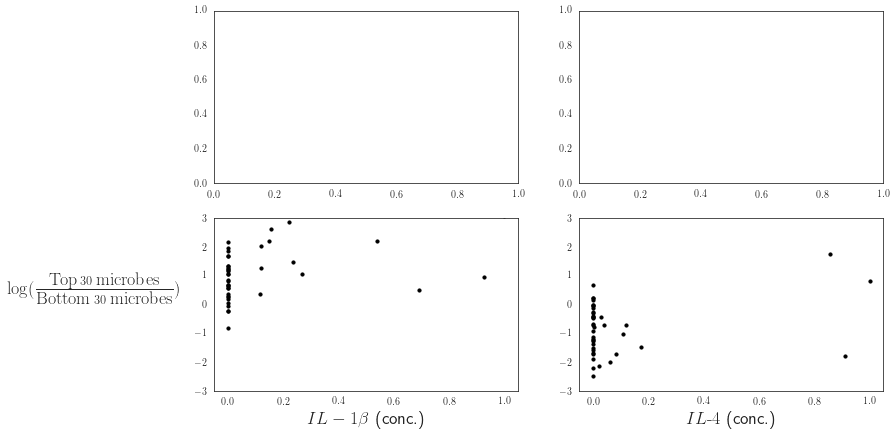

In [51]:
plt.rcParams['text.usetex'] = True
sns.set_style('white')

fs = 18
ls = 14

order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 
         'Desulfovibrio', 'Other']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
#palette['Other'] = '#808080'
#palette['Other'] = 'w'

# rename for latex
cytokine_k = ['IL1b', 'IL4']
#cytokine_v = ['IL6', r'TGF-$\beta$', r'IL-1$\beta$', 'IL4', r'IFN-$\gamma$']
cytokine_v = [r'IL-1\beta', r'IL\textrm{-}4']
lookup = dict(zip(cytokine_k, cytokine_v))

cytokine_names = cytokine_k

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharey=False)

def select_f(cyto_name, species_name):    
    if (cyto_name == 'IL6' or cyto_name == 'IL1b') and species_name == 'Prevotella copri':
        return True
    if cyto_name == 'TGFb' and species_name == 'Enterococcus faecalis':
        return True
    if cyto_name == 'IL6' and species_name == 'Bifidobacterium longum':
        return True
    else:
        return False

species_abv = {'Prevotella copri': 'P. copri', 
               'Enterococcus faecalis': 'E. faecalis',
               'Bifidobacterium longum': 'B. longum'}

## Scatter plots against cytokine concentrations
j = 1
eps = 1e-6
for i, cyto in enumerate(cytokine_k):
    il = top_balance(counts, avg_diffs[cyto], k)
    #il = microbe_balance(counts, taxmd)
    ax[j][i].scatter(amp_md[cyto], il, color='k', s=10)
    print(cyto, pearsonr(amp_md[cyto], il))
    #ax[j][i].set_ylabel(f'log(high {cyto} / low {cyto})')
    ax[j][i].set_ylabel('')
    ax[j][i].set_xlabel('$' + cytokine_v[i] + '$ (conc.)', fontsize=fs)
    ax[j][i].set_ylim([-3, 3])
    ax[j][i].set_xlim([-0.05, 1.05])
    
#ylabel = r'$\log(\frac{Enterococcus + Bifidobacterium}{Prevotella + Desulfovibrio})$'
ylabel = r'$\log(\frac{\textrm{Top} \;' + str(k) + '\; \\textrm{microbes}}{\\textrm{Bottom} \;' + str(k) + '\; \\textrm{microbes}})$'
ax[j][0].set_ylabel(ylabel, fontsize=fs, labelpad=100, rotation=0)
    
all_texts = []
j = 0
for i, cyto in enumerate(cytokine_names):
    df = diffs[['featureid', cyto, 'sample']].pivot(index='sample', columns='featureid', values=cyto)
    df_stats = ranking(df.T, reference_percentile=50, log_probs=True)
    # realign
    df_stats = pd.merge(df_stats, taxa_md, left_index=True, right_on='genome')
    df_stats['genome'] = df_stats['genome'].astype(np.str)
    df_stats = pd.merge(df_stats, amp_stats, left_on='genome', right_index=True)
    df_stats = df_stats.rename(columns={'mean_x': 'cytokine_mean', 'mean_y': 'amp_mean'})
    
    df_stats.index = list(map(str, df_stats.index))    
    legend = (i == (len(cytokine_names) - 2))
    #ax[j][i].vlines(lo, -1.2, 1.2, 'r', linestyle=':')
    #ax[j][i].vlines(hi, -1.2, 1.2, 'r', linestyle=':')
    lo = df_stats['cytokine_mean'].sort_values().iloc[k]
    hi = df_stats['cytokine_mean'].sort_values().iloc[-k]
    ax[j][i].axvspan(hi, 16, alpha=0.5, color='lavender', zorder=0)
    ax[j][i].axvspan(-16, lo, alpha=0.5, color='lightsalmon', zorder=0)
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[j][i], legend=False,  zorder=10,
                    s=100, hue_order=order, palette=palette, alpha=0.5)
    xlabel = r'$\log(\frac{\textrm{high }' + lookup[cyto] + '}{ \\textrm{low }' +  lookup[cyto] + '})$'
    
    ax[j][i].set_xlabel(xlabel, fontsize=fs)
    ax[j][i].set_ylabel("")
    ax[j][i].set_xlim([-16, 16])
    ax[j][i].set_ylim([-1.2, 1.2])
    ax[j][i].tick_params(axis='x', labelsize=ls)
    ax[j][i].tick_params(axis='y', labelsize=ls)
    
    idx = np.array(list(map(lambda x: select_f(cyto, x), df_stats['species'])))
    sub_taxdata = df_stats.loc[idx]
    sub_taxdata = sub_taxdata.drop_duplicates(subset=['species'])
    x = sub_taxdata['cytokine_mean'].values
    y = sub_taxdata['amp_mean'].values
    s = sub_taxdata['species'].values
    dx, dy = 0, 0
    if cyto == 'TGFb': 
        dx, dy = 2.7, 0
    if cyto == 'IL6': 
        dx, dy = -2.2, 0
    
    texts = [ax[j][i].text(x[k] + dx, y[k] + dy, f"\\textit{{{species_abv[s[k]]}}}", fontsize=16,
                        ha='center', va='center', zorder=20) 
             for k in range(len(x))]
    
ax[j][0].set_ylabel(r'$\log(\frac{\textrm{ASD}}{\textrm{Control}}) + K$', 
                    fontsize=fs, rotation=0, labelpad=50)

plt.tight_layout(w_pad=0.5)

In [ ]:
break

In [ ]:
cyto_means = diffs.groupby('featureid').mean()
cyto_means.index = list(map(str, cyto_means.index))
all_stats = pd.merge(amp_stats, cyto_means, left_index=True, right_index=True)
il6 = all_stats['IL6']
tgfb = all_stats['TGFb']
mdiffs = all_stats['mean']

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#ax[0].scatter(il6, mdiffs)
#ax[1].scatter(tgfb, mdiffs)

def default_differential_scatterplot(ax, dat, x, y, cyto):
    ax.set_xlim([-11, 11])
    ax.set_ylabel('log(ASD/Control) + K')
    ax.set_xlabel(f'log(high {cyto}/low {cyto}) + K')
    ax.scatter(x, y)
    sns.scatterplot(data=df_stats, x='cytokine_mean', y='amp_mean', hue='genera', 
                    ax=ax[i], legend=legend, 
                    s=100, hue_order=order, palette=palette, alpha=0.5)

In [ ]:
amp_stats.index

We will list the following microbes

Enterococcus faecalis, TGFb hinted in https://pubmed.ncbi.nlm.nih.gov/18286689/

Prevotella copri, hinted in
- https://pubmed.ncbi.nlm.nih.gov/31607556/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6854460/
- https://www.nature.com/articles/mi2013116.pdf
- https://elifesciences.org/articles/01202
- https://www.cell.com/cell/fulltext/S0092-8674(16)30659-6

Bifidobacterium longum, IL-1b hinted in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5142200/

